# Autoencoder

<img src="img/What are autoencoders 3.png"/>

What is an Autoencoder? [Two Minute Papers #86](https://www.youtube.com/watch?v=Rdpbnd0pCiI) 

A Gentle Autoencoder Tutorial [Benjamin Irving](https://github.com/benjaminirving/mlseminars-autoencoders) 

Building Autoencoders in Keras [Francois Chollet](https://blog.keras.io/building-autoencoders-in-keras.html) 

Auto-Encoders and Denoising Auto-Encoders [James Bergstra](https://github.com/jaberg/IPythonTheanoTutorials/blob/master/ipynb/Model%20-%20Autoencoders%20and%20Variations%20with%20PyAutodiff.ipynb)

How to autoencode your Pokémon [Niyas Mohammed](https://hackernoon.com/how-to-autoencode-your-pok%C3%A9mon-6b0f5c7b7d97) [code](https://github.com/niazangels/vae-pokedex)

CS294A Sparse Autoencoder Lecture by Andrew Ng 
[1/2](https://www.youtube.com/watch?v=vfnxKO2rMq4)
[2/2](https://www.youtube.com/watch?v=wqhZaWR-J94)

Autoencoders, Unsupervised Learning, and Deep Architectures [Pierre Baldi](http://proceedings.mlr.press/v27/baldi12a/baldi12a.pdf)

# Denoising autoencoder

<img src="img/Denoising autoencoder.png"/>

In [ ]:
# 1 Noise reduction of 3D graph

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
import random
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


class NeuralNet:
    def __init__(self, n_in, n_out, n_hid, act_ft, lr, bn_lr):
        """
        :param n_in: input dimension
        :param n_out: output dimension
        :param n_hid: list, hidden layer
        :param act_ft: string, activated function
        :param lr: float, learning rate
        :param bn_lr: float, learning rate of batch normalization
        """
        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid  # list
        self.act_ft = act_ft
        self.lr = lr
        self.bn_lr = bn_lr

        self.num_layer = len(self.n_hid)

        if self.act_ft is 'sig':
            self.act = tf.nn.sigmoid
            self.b_init = 0.00
        elif self.act_ft is 'tanh':
            self.act = tf.nn.tanh
            self.b_init = 0.00
        elif self.act_ft is 'relu':
            self.act = tf.nn.relu
            self.b_init = 0.01
        elif self.act_ft is 'elu':
            self.act = tf.nn.elu
            self.b_init = 0.00

        # placeholder
        self.phase_train = tf.placeholder(dtype=tf.bool, name='phase')
        self.input_holder = tf.placeholder(dtype=tf.float32, name='input')
        self.target = tf.placeholder(dtype=tf.float32, name='target')
        self.output = [self.input_holder]

        # train
        self.logits = self.inference()
        self.opt = tf.train.AdamOptimizer(self.lr)  # default 0.001
        self.train_op = self.opt.minimize(self.loss())

    def weight_var(self, n_in, n_out):
        weight = tf.get_variable(name='weight', shape=[n_in, n_out],
                                 initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('weight', weight)
        return weight

    def bias_var(self, n_out, b_init):
        bias = tf.get_variable(name='bias', initializer=tf.constant(b_init, shape=[n_out]))
        tf.summary.histogram('bias', bias)
        return bias

    def inference(self):

        # hidden layer
        with tf.variable_scope('layer0'):
            W = self.weight_var(self.n_in, self.n_hid[0])
            b = self.bias_var(self.n_hid[0], self.b_init)
            output = self.act(tf.matmul(self.output[-1], W) + b)
            # pre = tf.matmul(self.output[-1], W)
            # normed1, normed2 = self.batch_norm(pre, self.n_hid[0], self.bn_lr)
            # normed = tf.where(self.phase_train, normed1, normed2)
            # output = self.act(normed)
            self.output.append(output)

        for i in range(self.num_layer-1):
            with tf.variable_scope('layer'+str(i+1)):
                W = self.weight_var(self.n_hid[i], self.n_hid[i+1])
                b = self.bias_var(self.n_hid[i+1], self.b_init)
                output = self.act(tf.matmul(self.output[-1], W) + b)
                # pre = tf.matmul(self.output[-1], W)
                # normed1, normed2 = self.batch_norm(pre, self.n_hid[i+1], self.bn_lr)
                # normed = tf.where(self.phase_train, normed1, normed2)
                # output = self.act(normed)
                self.output.append(output)

        # output layer
        with tf.variable_scope('output'):
            W = self.weight_var(self.n_hid[-1], self.n_out)
            b = self.bias_var(self.n_out, 0.00)
            output = self.act(tf.matmul(self.output[-1], W) + b)
            self.output.append(output)
            return self.output[-1]

    def loss(self):
        loss = tf.reduce_mean(tf.square(self.logits - self.target), name='loss')
        tf.summary.scalar('loss', loss)
        return loss

    def batch_norm(self, t, n_out, bn_lr):

        with tf.variable_scope('bn'):
            scale = tf.Variable(tf.constant(1.0, shape=[n_out]), name='scale')
            offset = tf.Variable(tf.constant(0.0, shape=[n_out]), name='offset')
            ema_mean = tf.Variable(tf.constant(0.0, shape=[n_out]), name='ema_mean')
            ema_var = tf.Variable(tf.constant(1.0, shape=[n_out]), name='ema_var')

            batch_mean, batch_var = tf.nn.moments(t, axes=[0], name='moments')
            ema = tf.train.ExponentialMovingAverage(decay=1.0 - bn_lr)
            ema_apply_op = ema.apply([batch_mean, batch_var])
            ema_mean_var_assign_op = [ema_mean.assign(ema.average(batch_mean)),
                                      ema_var.assign(ema.average(batch_var))]

            with tf.control_dependencies([ema_apply_op]):
                with tf.control_dependencies(ema_mean_var_assign_op):
                    bm = tf.identity(batch_mean)
                    bv = tf.identity(batch_var)
                    em = tf.identity(ema_mean)
                    ev = tf.identity(ema_var)

            normed1 = tf.nn.batch_normalization(t, bm, bv, offset, scale, variance_epsilon=1e-3)
            normed2 = tf.nn.batch_normalization(t, em, ev, offset, scale, variance_epsilon=1e-3)

            tf.summary.histogram('offset', offset)
            tf.summary.histogram('scale', scale)
            tf.summary.histogram('moving_avg_mean', ema_mean)
            tf.summary.histogram('moving_avg_var', ema_var)

            return normed1, normed2



if __name__ == '__main__':

    # parameter
    num_train = 50000
    batch_size = 400

    x = np.arange(-1, 1, 0.05)
    y = np.arange(-1, 1, 0.05)
    x_grid, y_grid = np.meshgrid(x, y)
    z0_grid = x_grid**2 + y_grid**2

    np.random.seed(1)
    e = np.random.randn(x_grid.shape[0], x_grid.shape[1])
    z_grid = z0_grid + 0.3*e

    X = x_grid.reshape([-1, 1])
    Y = y_grid.reshape([-1, 1])
    Z = z_grid.reshape([-1, 1])

    samples = np.hstack([X, Y, Z])

    with tf.Session() as sess:
        nnet = NeuralNet(3, 3, [10, 10, 2, 10, 10], 'elu', 0.001, 0.001)
        init_op = tf.global_variables_initializer()
        merged_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(logdir='./test2', graph=sess.graph)
        sess.run(init_op)

        # train
        for i in range(num_train):
            minibatch = samples[random.sample(range(samples.shape[0]), batch_size), :]
            sess.run(nnet.train_op, feed_dict={nnet.input_holder: minibatch,
                                               nnet.target: minibatch, nnet.phase_train: True})

            if i % 100 == 0:
                summary = sess.run(merged_op, feed_dict={nnet.input_holder: minibatch,
                                                         nnet.target: minibatch, nnet.phase_train: True})
                summary_writer.add_summary(summary, global_step=i)

            if i % 1000 == 0:
                print('train %d' % (i + 1000), sess.run(nnet.loss(),
                                                        feed_dict={nnet.input_holder: minibatch,
                                                                   nnet.target: minibatch, nnet.phase_train: True}))

        P = sess.run(nnet.logits, feed_dict={nnet.input_holder: samples, nnet.phase_train: False})
        xp = P[:, 0].reshape([x_grid.shape[0], x_grid.shape[1]])
        yp = P[:, 1].reshape([x_grid.shape[0], x_grid.shape[1]])
        zp = P[:, 2].reshape([x_grid.shape[0], x_grid.shape[1]])

        # visualization
        fig1 = plt.figure()
        ax = fig1.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z0_grid,
                        rstride=1,  # row step size
                        cstride=1,  # column step size
                        cmap=cm.coolwarm,  # color map
                        linewidth=0,  # wireframe line width
                        antialiased=False)
        ax.set_title('Original')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])
        # ax.colorbar

        fig2 = plt.figure(2)
        ax = fig2.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Input')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        fig3 = plt.figure(3)
        ax = fig3.gca(projection='3d')
        ax.plot_surface(xp, yp, zp, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Output')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        plt.show()

In [ ]:
# 2 Noise reduction of 3D graph - symmetric

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
import random
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


class NeuralNet:
    def __init__(self, enc, act_ft):
        """
        :param enc: list, encoder
        :param act_ft: string, activated function
        """
        self.enc = enc  # list
        self.act_ft = act_ft

        if self.act_ft is 'sig':
            self.act = tf.nn.sigmoid
            self.b_init = 0.00
        elif self.act_ft is 'tanh':
            self.act = tf.nn.tanh
            self.b_init = 0.00
        elif self.act_ft is 'relu':
            self.act = tf.nn.relu
            self.b_init = 0.01
        elif self.act_ft is 'elu':
            self.act = tf.nn.elu
            self.b_init = 0.00

        # placeholder
        self.input_holder = tf.placeholder(dtype=tf.float32, name='input')
        self.target = tf.placeholder(dtype=tf.float32, name='target')
        self.output = [self.input_holder]


        # train
        self.logits = self.inference()
        self.opt = tf.train.AdamOptimizer()  # default 0.001
        self.train_op = self.opt.minimize(self.loss())

    def weight_var(self, n_in, n_out, layer_name):
        weight = tf.get_variable(name='W'+str(layer_name), shape=[n_in, n_out],
                                 initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('weight', weight)
        return weight

    def bias_var(self, n_out, b_init, layer_name):
        bias = tf.get_variable(name='b'+str(layer_name), initializer=tf.constant(b_init, shape=[n_out]))
        tf.summary.histogram('bias', bias)
        return bias

    def inference(self):

        with tf.variable_scope('encoder'):
            W1 = self.weight_var(self.enc[0], self.enc[1], 1)
            b1 = self.bias_var(self.enc[1], self.b_init, 1)
            output = self.act(tf.matmul(self.output[-1], W1) + b1)
            self.output.append(output)

            W2 = self.weight_var(self.enc[1], self.enc[2], 2)
            b2 = self.bias_var(self.enc[2], self.b_init, 2)
            output = self.act(tf.matmul(self.output[-1], W2) + b2)
            self.output.append(output)

            W3 = self.weight_var(self.enc[2], self.enc[3], 3)
            b3 = self.bias_var(self.enc[3], self.b_init, 3)
            output = self.act(tf.matmul(self.output[-1], W3) + b3)
            self.output.append(output)

            # W4 = self.weight_var(self.enc[3], self.enc[4], 4)
            # b4 = self.bias_var(self.enc[4], self.b_init, 4)
            # output = self.act(tf.matmul(self.output[-1], W4) + b4)
            # self.output.append(output)

        with tf.variable_scope('encoder', reuse=True):
            W1c = tf.get_variable(name='W'+str(1), shape=[self.enc[0], self.enc[1]])
            W2c = tf.get_variable(name='W'+str(2), shape=[self.enc[1], self.enc[2]])
            W3c = tf.get_variable(name='W'+str(3), shape=[self.enc[2], self.enc[3]])
            # W4c = tf.get_variable(name='W'+str(4), shape=[self.enc[3], self.enc[4]])

        with tf.variable_scope('decoder'):
            # W5 = tf.transpose(W4c)
            # b5 = self.bias_var(self.enc[3], self.b_init, 5)
            # output = self.act(tf.matmul(self.output[-1], W5) + b5)
            # self.output.append(output)

            W6 = tf.transpose(W3c)
            b6 = self.bias_var(self.enc[2], self.b_init, 6)
            output = self.act(tf.matmul(self.output[-1], W6) + b6)
            self.output.append(output)

            W7 = tf.transpose(W2c)
            b7 = self.bias_var(self.enc[1], self.b_init, 7)
            output = self.act(tf.matmul(self.output[-1], W7) + b7)
            self.output.append(output)

            W8 = tf.transpose(W1c)
            b8 = self.bias_var(self.enc[0], 0.00, 8)
            output = self.act(tf.matmul(self.output[-1], W8) + b8)
            self.output.append(output)
            return self.output[-1]

    def loss(self):
        loss = tf.reduce_mean(tf.square(self.logits - self.target), name='loss')
        tf.summary.scalar('loss', loss)
        return loss


if __name__ == '__main__':

    # parameter
    num_train = 50000
    batch_size = 400

    x = np.arange(-1, 1, 0.05)
    y = np.arange(-1, 1, 0.05)
    x_grid, y_grid = np.meshgrid(x, y)
    z0_grid = x_grid**2 + y_grid**2

    np.random.seed(1)
    e = np.random.randn(x_grid.shape[0], x_grid.shape[1])
    z_grid = z0_grid + 0.3*e

    X = x_grid.reshape([-1, 1])
    Y = y_grid.reshape([-1, 1])
    Z = z_grid.reshape([-1, 1])

    samples = np.hstack([X, Y, Z])

    with tf.Session() as sess:
        nnet = NeuralNet([3, 10, 10, 2], 'elu')
        init_op = tf.global_variables_initializer()
        merged_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(logdir='./test', graph=sess.graph)
        sess.run(init_op)

        # train
        for i in range(num_train):
            minibatch = samples[random.sample(range(samples.shape[0]), batch_size), :]
            sess.run(nnet.train_op, feed_dict={nnet.input_holder: minibatch, nnet.target: minibatch})

            if i % 100 == 0:
                summary = sess.run(merged_op, feed_dict={nnet.input_holder: minibatch, nnet.target: minibatch})
                summary_writer.add_summary(summary, global_step=i)

            if i % 1000 == 0:
                print('train %d' % (i + 1000), sess.run(nnet.loss(), feed_dict={nnet.input_holder: minibatch,
                                                                                nnet.target: minibatch}))

        P = sess.run(nnet.logits, feed_dict={nnet.input_holder: samples})
        xp = P[:, 0].reshape([x_grid.shape[0], x_grid.shape[1]])
        yp = P[:, 1].reshape([x_grid.shape[0], x_grid.shape[1]])
        zp = P[:, 2].reshape([x_grid.shape[0], x_grid.shape[1]])

        # visualization
        fig1 = plt.figure()
        ax = fig1.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z0_grid,
                        rstride=1,  # row step size
                        cstride=1,  # column step size
                        cmap=cm.coolwarm,  # color map
                        linewidth=0,  # wireframe line width
                        antialiased=False)
        ax.set_title('Original')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])
        # ax.colorbar

        fig2 = plt.figure(2)
        ax = fig2.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Input')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        fig3 = plt.figure(3)
        ax = fig3.gca(projection='3d')
        ax.plot_surface(xp, yp, zp, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Output-enc')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        plt.show()


In [ ]:
# 3 Noise reduction of 3D graph - train

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt, nn_pca as nn
import random
import sample
from mpl_toolkits.mplot3d import Axes3D

# sample data
x_grid, y_grid, z_grid, samples = sample.data(-1, 1, 0.05)

# parameter
num_train = 5000
batch_size = 400

with tf.Session() as sess:
    nnet = nn.NeuralNet(3, 3, [10, 10, 10, 2, 10, 10, 10])
    merged_op = tf.summary.merge_all()
    summary_writer = tf.summary.FileWriter(logdir='./test', graph=sess.graph)
    #saver = tf.train.Saver()
    tf.global_variables_initializer().run()

    # train
    aux = np.arange(samples.shape[0])
    for i in range(num_train):
        minibatch = samples[random.sample(aux, batch_size), :]
        sess.run(nnet.train_op, feed_dict={nnet.input_holder: minibatch, nnet.target: minibatch})
        if i % 20 == 0:
            print('train %d' % (i + 1), sess.run(nnet.loss(), feed_dict={nnet.input_holder: minibatch, nnet.target: minibatch}))
        if i % 1000 == 0:
            summary = sess.run(merged_op)
            summary_writer.add_summary(summary, global_step=i)
    saver = tf.train.Saver()
    saver.save(sess, "./tmp/train.ckpt")

# sample data
x_grid, y_grid, z_grid, samples = sample.data(-1, 1, 0.05)

# graph
with tf.Session() as sess:
    nnet = nn.NeuralNet(3, 3, [10, 10, 10, 2, 10, 10, 10])
    saver = tf.train.Saver()
    saver.restore(sess, './tmp/train.ckpt')

    P = sess.run(nnet.logits, feed_dict={nnet.input_holder: samples})
    xp = P[:, 0].reshape([x_grid.shape[0], x_grid.shape[1]])
    yp = P[:, 1].reshape([x_grid.shape[0], x_grid.shape[1]])
    zp = P[:, 2].reshape([x_grid.shape[0], x_grid.shape[1]])

    # visualization
    fig1 = plt.figure(1)
    a = fig1.gca(projection='3d')
    a.plot_surface(x_grid, y_grid, z_grid)

    fig2 = plt.figure(2)
    a = fig2.gca(projection='3d')
    a.plot_surface(xp, yp, zp)

    plt.show()

In [ ]:
# 4 Noise reduction of 3D graph - test

import tensorflow as tf
import nn_pca as nn
import sample
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# sample data
x_grid, y_grid, z_grid, samples = sample.data(-1, 1, 0.05)

# graph
with tf.Session() as sess:
    nnet = nn.NeuralNet(3, 3, [10, 10, 10, 2, 10, 10, 10])
    saver = tf.train.Saver()
    saver.restore(sess, './tmp/train.ckpt')

    P = sess.run(nnet.logits, feed_dict={nnet.input_holder: samples})
    xp = P[:, 0].reshape([x_grid.shape[0], x_grid.shape[1]])
    yp = P[:, 1].reshape([x_grid.shape[0], x_grid.shape[1]])
    zp = P[:, 2].reshape([x_grid.shape[0], x_grid.shape[1]])

    # visualization
    fig1 = plt.figure(1)
    a = fig1.gca(projection='3d')
    a.plot_surface(x_grid, y_grid, z_grid)

    fig2 = plt.figure(2)
    a = fig2.gca(projection='3d')
    a.plot_surface(xp, yp, zp)

    plt.show()

train 1000 0.508876
train 2000 0.0186576
train 3000 0.0118179
train 4000 0.00984059
train 5000 0.0108941
train 6000 0.00961671
train 7000 0.00879241
train 8000 0.00893815
train 9000 0.00786401
train 10000 0.00912589
train 11000 0.00845028
train 12000 0.0091116
train 13000 0.00852579
train 14000 0.008529
train 15000 0.00856547
train 16000 0.00811981
train 17000 0.00811921
train 18000 0.0086883
train 19000 0.00916868
train 20000 0.00804798
train 21000 0.00827345
train 22000 0.00827742
train 23000 0.00904028
train 24000 0.00802945
train 25000 0.00747813
train 26000 0.00852884
train 27000 0.00785408
train 28000 0.00701675
train 29000 0.00806705
train 30000 0.00827128
train 31000 0.00832825
train 32000 0.00717119
train 33000 0.0072038
train 34000 0.00791268
train 35000 0.00845349
train 36000 0.0078359
train 37000 0.00704059
train 38000 0.00733732
train 39000 0.00812415
train 40000 0.00830288
train 41000 0.00815788
train 42000 0.00779114
train 43000 0.00831191
train 44000 0.00748787
train 45

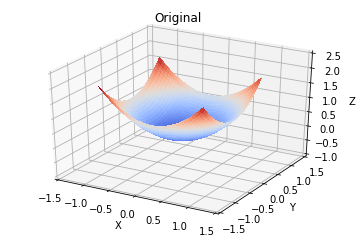

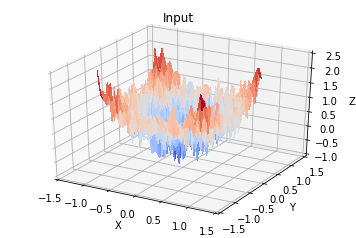

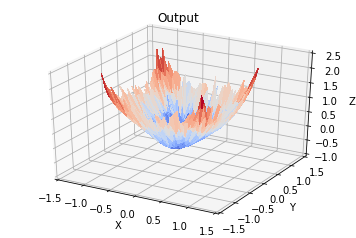

In [1]:
# toy demonstration of auto-encoder

import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
import random
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


class NeuralNet:
    def __init__(self, n_in, n_out, n_hid, act_ft, lr, bn_lr):
        """
        :param n_in: input dimension
        :param n_out: output dimension
        :param n_hid: list, hidden layer
        :param act_ft: string, activated function
        :param lr: float, learning rate
        :param bn_lr: float, learning rate of batch normalization
        """
        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid  # list
        self.act_ft = act_ft
        self.lr = lr
        self.bn_lr = bn_lr

        self.num_layer = len(self.n_hid)

        if self.act_ft is 'sig':
            self.act = tf.nn.sigmoid
            self.b_init = 0.00
        elif self.act_ft is 'tanh':
            self.act = tf.nn.tanh
            self.b_init = 0.00
        elif self.act_ft is 'relu':
            self.act = tf.nn.relu
            self.b_init = 0.01
        elif self.act_ft is 'elu':
            self.act = tf.nn.elu
            self.b_init = 0.00

        # placeholder
        self.phase_train = tf.placeholder(dtype=tf.bool, name='phase')
        self.input_holder = tf.placeholder(dtype=tf.float32, name='input')
        self.target = tf.placeholder(dtype=tf.float32, name='target')
        self.output = [self.input_holder]

        # train
        self.logits = self.inference()
        self.opt = tf.train.AdamOptimizer(self.lr)  # default 0.001
        self.train_op = self.opt.minimize(self.loss())

    def weight_var(self, n_in, n_out):
        weight = tf.get_variable(name='weight', shape=[n_in, n_out],
                                 initializer=tf.contrib.layers.xavier_initializer())
        tf.summary.histogram('weight', weight)
        return weight

    def bias_var(self, n_out, b_init):
        bias = tf.get_variable(name='bias', initializer=tf.constant(b_init, shape=[n_out]))
        tf.summary.histogram('bias', bias)
        return bias

    def inference(self):

        # hidden layer
        with tf.variable_scope('layer0'):
            W = self.weight_var(self.n_in, self.n_hid[0])
            b = self.bias_var(self.n_hid[0], self.b_init)
            output = self.act(tf.matmul(self.output[-1], W) + b)
            # pre = tf.matmul(self.output[-1], W)
            # normed1, normed2 = self.batch_norm(pre, self.n_hid[0], self.bn_lr)
            # normed = tf.where(self.phase_train, normed1, normed2)
            # output = self.act(normed)
            self.output.append(output)

        for i in range(self.num_layer-1):
            with tf.variable_scope('layer'+str(i+1)):
                W = self.weight_var(self.n_hid[i], self.n_hid[i+1])
                b = self.bias_var(self.n_hid[i+1], self.b_init)
                output = self.act(tf.matmul(self.output[-1], W) + b)
                # pre = tf.matmul(self.output[-1], W)
                # normed1, normed2 = self.batch_norm(pre, self.n_hid[i+1], self.bn_lr)
                # normed = tf.where(self.phase_train, normed1, normed2)
                # output = self.act(normed)
                self.output.append(output)

        # output layer
        with tf.variable_scope('output'):
            W = self.weight_var(self.n_hid[-1], self.n_out)
            b = self.bias_var(self.n_out, 0.00)
            output = self.act(tf.matmul(self.output[-1], W) + b)
            self.output.append(output)
            return self.output[-1]

    def loss(self):
        loss = tf.reduce_mean(tf.square(self.logits - self.target), name='loss')
        tf.summary.scalar('loss', loss)
        return loss

    def batch_norm(self, t, n_out, bn_lr):

        with tf.variable_scope('bn'):
            scale = tf.Variable(tf.constant(1.0, shape=[n_out]), name='scale')
            offset = tf.Variable(tf.constant(0.0, shape=[n_out]), name='offset')
            ema_mean = tf.Variable(tf.constant(0.0, shape=[n_out]), name='ema_mean')
            ema_var = tf.Variable(tf.constant(1.0, shape=[n_out]), name='ema_var')

            batch_mean, batch_var = tf.nn.moments(t, axes=[0], name='moments')
            ema = tf.train.ExponentialMovingAverage(decay=1.0 - bn_lr)
            ema_apply_op = ema.apply([batch_mean, batch_var])
            ema_mean_var_assign_op = [ema_mean.assign(ema.average(batch_mean)),
                                      ema_var.assign(ema.average(batch_var))]

            with tf.control_dependencies([ema_apply_op]):
                with tf.control_dependencies(ema_mean_var_assign_op):
                    bm = tf.identity(batch_mean)
                    bv = tf.identity(batch_var)
                    em = tf.identity(ema_mean)
                    ev = tf.identity(ema_var)

            normed1 = tf.nn.batch_normalization(t, bm, bv, offset, scale, variance_epsilon=1e-3)
            normed2 = tf.nn.batch_normalization(t, em, ev, offset, scale, variance_epsilon=1e-3)

            tf.summary.histogram('offset', offset)
            tf.summary.histogram('scale', scale)
            tf.summary.histogram('moving_avg_mean', ema_mean)
            tf.summary.histogram('moving_avg_var', ema_var)

            return normed1, normed2

        
if __name__ == '__main__':

    # parameter
    num_train = 50000
    batch_size = 400

    x = np.arange(-1, 1, 0.05)
    y = np.arange(-1, 1, 0.05)
    x_grid, y_grid = np.meshgrid(x, y)
    z0_grid = x_grid**2 + y_grid**2

    np.random.seed(1)
    e = np.random.randn(x_grid.shape[0], x_grid.shape[1])
    z_grid = z0_grid + 0.3*e

    X = x_grid.reshape([-1, 1])
    Y = y_grid.reshape([-1, 1])
    Z = z_grid.reshape([-1, 1])

    samples = np.hstack([X, Y, Z])

    with tf.Session() as sess:
        nnet = NeuralNet(3, 3, [10, 10, 2, 10, 10], 'elu', 0.001, 0.001)
        init_op = tf.global_variables_initializer()
        merged_op = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(logdir='./test2', graph=sess.graph)
        sess.run(init_op)

        # train
        for i in range(num_train):
            minibatch = samples[random.sample(range(samples.shape[0]), batch_size), :]
            sess.run(nnet.train_op, feed_dict={nnet.input_holder: minibatch,
                                               nnet.target: minibatch, nnet.phase_train: True})

            if i % 100 == 0:
                summary = sess.run(merged_op, feed_dict={nnet.input_holder: minibatch,
                                                         nnet.target: minibatch, nnet.phase_train: True})
                summary_writer.add_summary(summary, global_step=i)

            if i % 1000 == 0:
                print('train %d' % (i + 1000), sess.run(nnet.loss(),
                                                        feed_dict={nnet.input_holder: minibatch,
                                                                   nnet.target: minibatch, nnet.phase_train: True}))

        P = sess.run(nnet.logits, feed_dict={nnet.input_holder: samples, nnet.phase_train: False})
        xp = P[:, 0].reshape([x_grid.shape[0], x_grid.shape[1]])
        yp = P[:, 1].reshape([x_grid.shape[0], x_grid.shape[1]])
        zp = P[:, 2].reshape([x_grid.shape[0], x_grid.shape[1]])

        # visualization
        fig1 = plt.figure()
        ax = fig1.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z0_grid,
                        rstride=1,  # row step size
                        cstride=1,  # column step size
                        cmap=cm.coolwarm,  # color map
                        linewidth=0,  # wireframe line width
                        antialiased=False)
        ax.set_title('Original')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])
        # ax.colorbar

        fig2 = plt.figure(2)
        ax = fig2.gca(projection='3d')
        ax.plot_surface(x_grid, y_grid, z_grid, rstride=1, cstride=1,
                        cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Input')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        fig3 = plt.figure(3)
        ax = fig3.gca(projection='3d')
        ax.plot_surface(xp, yp, zp, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax.set_title('Output')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])
        ax.set_zlim([-1.0, 2.5])

        plt.show()

# Exercise.

Modify above codes and make a code for the PCA.